In [71]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans

In [72]:
esg_data = pd.read_csv("esg_scores_2021.csv")
financial_data = pd.read_csv("filtered_security_data.csv")
price_data = pd.read_csv("snp500_stocks_closing_price_daily_data.csv")

In [73]:
data = esg_data.merge(financial_data, on='symbol', how='inner')

In [74]:
factor_cols = [
'priceToBook',
'priceToSalesTrailing12Months',
'trailingPE',
'profitMargins',
'52WeekChange',
'revenueQuarterlyGrowth'
]

for col in factor_cols:
    if col not in data.columns:
        data[col] = np.nan

In [75]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

In [76]:
data['value_factor'] = (
-zscore(data['priceToBook'])
-zscore(data['priceToSalesTrailing12Months'])
-zscore(data['trailingPE'])
)
data['quality_factor'] = zscore(data['profitMargins'])
data['momentum_factor'] = zscore(data['52WeekChange'])
data['growth_factor'] = zscore(data['revenueQuarterlyGrowth'])
data['esg_factor'] = zscore(data['totalEsg'])

In [77]:
data['composite_score'] = (
1.0 * data['value_factor'] +
1.0 * data['quality_factor'] +
1.0 * data['momentum_factor'] +
1.0 * data['growth_factor'] +
1.0 * data['esg_factor']
)

In [78]:
if 'averageVolume' in data.columns:
    data = data[data['averageVolume'] > 1e6].copy()
else:
    print("Warning: 'averageVolume' column not found, skipping liquidity filter.")

In [79]:
median_esg = data['totalEsg'].median()
data = data[data['totalEsg'] >= median_esg].copy()

In [80]:
if 'sector' not in data.columns:
    raise ValueError("No 'sector' column found in data. Please ensure your data has a sector column.")

In [81]:
factor_cols_for_clustering = [
'value_factor',
'quality_factor',
'momentum_factor',
'growth_factor',
'esg_factor'
]

In [82]:
print(f"Sector: {sector_name}, NaN count per column:\n", subset[factor_cols_for_clustering].isna().sum())


Sector: Communication Services, NaN count per column:
 value_factor       0
quality_factor     0
momentum_factor    0
growth_factor      0
esg_factor         0
dtype: int64


In [83]:
all_clustered = []

clusters_per_sector = 3

for sector_name in data['sector'].unique():
    subset = data[data['sector'] == sector_name].copy()

    if len(subset) < clusters_per_sector:
        subset['kmeans_factor_cluster'] = 0
        all_clustered.append(subset)
        continue  # Skip clustering for small sectors

    # Fill NaNs with sector-specific mean
    subset[factor_cols_for_clustering] = subset[factor_cols_for_clustering].apply(
        lambda x: x.fillna(x.mean()), axis=0
    )

    # Debugging: Print NaN counts
    print(f"Sector: {sector_name}, NaN count per column after filling:\n", subset[factor_cols_for_clustering].isna().sum())

    # Drop rows where NaNs remain
    subset.dropna(subset=factor_cols_for_clustering, inplace=True)

    # Ensure enough rows remain for clustering
    if subset.shape[0] < clusters_per_sector:
        subset['kmeans_factor_cluster'] = 0
    else:
        X = subset[factor_cols_for_clustering].values
        kmeans = KMeans(n_clusters=clusters_per_sector, random_state=42)
        kmeans.fit(X)

        subset['kmeans_factor_cluster'] = kmeans.labels_

    all_clustered.append(subset)


Sector: Industrials, NaN count per column after filling:
 value_factor        0
quality_factor      0
momentum_factor    23
growth_factor      23
esg_factor          0
dtype: int64
Sector: Healthcare, NaN count per column after filling:
 value_factor        0
quality_factor      0
momentum_factor    23
growth_factor      23
esg_factor          0
dtype: int64
Sector: Utilities, NaN count per column after filling:
 value_factor        0
quality_factor      0
momentum_factor    25
growth_factor      25
esg_factor          0
dtype: int64
Sector: Financial Services, NaN count per column after filling:
 value_factor        0
quality_factor      0
momentum_factor    24
growth_factor      24
esg_factor          0
dtype: int64
Sector: Basic Materials, NaN count per column after filling:
 value_factor        0
quality_factor      0
momentum_factor    10
growth_factor      10
esg_factor          0
dtype: int64
Sector: Consumer Defensive, NaN count per column after filling:
 value_factor        0


In [84]:
data_clustered = pd.concat(all_clustered, ignore_index=True)



In [86]:
top_n_per_cluster = 5 # number of picks from each cluster


final_picks = []

for sector_name in data_clustered['sector'].unique():
    sector_subset = data_clustered[data_clustered['sector'] == sector_name]

for c_label in sector_subset['kmeans_factor_cluster'].unique():
    cluster_subset = sector_subset[sector_subset['kmeans_factor_cluster'] == c_label]
# Sort by composite_score descending, pick top 5 (or top_n_per_cluster)
picked = cluster_subset.nlargest(top_n_per_cluster, 'composite_score')
final_picks.append(picked)

selected_stocks_kmeans_2layer = pd.concat(final_picks, ignore_index=True)

In [87]:
selected_stocks_kmeans_2layer = data_clustered.nlargest(30, 'composite_score')
print("Selected stocks from two-layer clustering:")
print(selected_stocks_kmeans_2layer[['symbol', 'sector', 'kmeans_factor_cluster', 'composite_score']])

Selected stocks from two-layer clustering:
  symbol sector  kmeans_factor_cluster  composite_score
0    BSX      0                      0              NaN
1     GD      0                      0              NaN


In [88]:
initial_weights = np.full(len(selected_stocks_kmeans_2layer), 1.0 / len(selected_stocks_kmeans_2layer))
portfolio = pd.DataFrame({
'symbol': selected_stocks_kmeans_2layer['symbol'],
'weight': initial_weights
})

In [89]:
price_data.set_index('symbol', inplace=True)



In [90]:
price_data = price_data.sort_index(axis=1)



In [91]:
numeric_cols = [c for c in price_data.columns if pd.api.types.is_numeric_dtype(price_data[c])]
price_data = price_data[numeric_cols]



In [92]:
price_data = price_data.loc[portfolio['symbol'].values]



In [93]:
price_data = price_data.T



In [94]:
price_data.index = pd.to_datetime(price_data.index, errors='coerce')
price_data.sort_index(inplace=True)

returns = price_data.pct_change().dropna(how='all').fillna(0)

In [ ]:
def mean_variance_optimization(returns_df):
    """
    Simple mean-variance optimization: maximize return - 0.5*risk.
    Subject to sum of weights == 1 and weights >= 0.
    """
    symbols = returns_df.columns
    n = len(symbols)
    mu = returns_df.mean().values.reshape(-1, 1)
    Sigma = returns_df.cov().values

    w = cp.Variable((n, 1), nonneg=True)
    risk = cp.quad_form(w, Sigma)
    ret = mu.T @ w
    objective = cp.Maximize(ret - 0.5 * risk)
    constraints = [cp.sum(w) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP)  # or another solver
    
    return w.value.flatten()



optimized_weights = mean_variance_optimization(returns)



In [98]:
portfolio = portfolio.set_index('symbol')

for i, sym in enumerate(returns.columns):
    portfolio.loc[sym, 'mv_weight'] = optimized_weights[i]

portfolio.reset_index(inplace=True)


In [99]:
def backtest_portfolio(
    portfolio_df,
    raw_price_data,
    weight_col='mv_weight',
    sp500_csv_path="snp500_INDEX_daily_closing_prices.csv"
):
    """
    Backtest a portfolio against provided daily price data
    and compare with S&P 500 index.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Compute portfolio's cumulative returns
    subset_symbols = portfolio_df['symbol'].unique()
    price_subset = raw_price_data[subset_symbols].copy()
    daily_returns = price_subset.pct_change().fillna(0)

    weight_map = portfolio_df.set_index('symbol')[weight_col]
    portfolio_returns = daily_returns.dot(weight_map)
    cumulative_returns = (1 + portfolio_returns).cumprod()

    start_value = cumulative_returns.iloc[0]
    end_value = cumulative_returns.iloc[-1]
    num_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    # Load S&P 500 index data
    sp500_data = pd.read_csv(sp500_csv_path)
    sp500_data['Date'] = pd.to_datetime(sp500_data['Date'], format='%b %d, %Y', errors='coerce')
    sp500_data.set_index('Date', inplace=True)
    sp500_data.sort_index(inplace=True)

    sp500_data['daily_return'] = sp500_data['Close Price'].pct_change().fillna(0)
    sp500_data['cumulative_sp500'] = (1 + sp500_data['daily_return']).cumprod()

    # Align dates between portfolio and S&P 500
    common_index = cumulative_returns.index.intersection(sp500_data.index)
    portfolio_cum_aligned = cumulative_returns.loc[common_index]
    sp500_cum_aligned = sp500_data['cumulative_sp500'].loc[common_index]

    # Plot results
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    # Plot portfolio
    plt.plot(portfolio_cum_aligned.index, portfolio_cum_aligned.values,
             label=f"Portfolio ({weight_col})", linewidth=2, color='royalblue')
    
    # Plot S&P 500
    plt.plot(sp500_cum_aligned.index, sp500_cum_aligned.values,
             label="S&P 500", linewidth=2, color='red')
    
    plt.title(f"Portfolio vs. S&P 500 (Portfolio CAGR: {cagr:.2%})", fontsize=16, fontweight='bold')
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Cumulative Return", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return portfolio_cum_aligned, sp500_cum_aligned, cagr


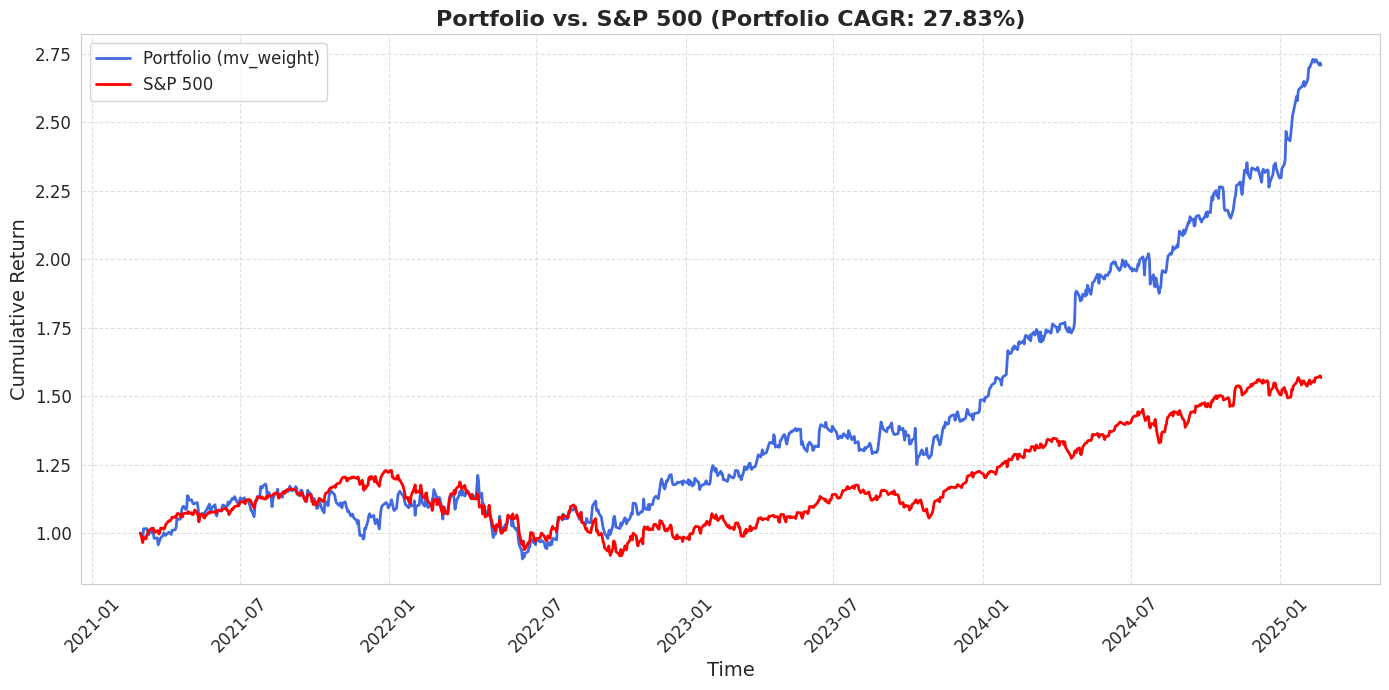

CAGR for Two-Layer Clustered Mean-Variance Portfolio: 27.83%


In [100]:
portfolio_cum_aligned, sp500_cum_aligned, cagr_mv = backtest_portfolio(portfolio, price_data, 'mv_weight')
print(f"CAGR for Two-Layer Clustered Mean-Variance Portfolio: {cagr_mv:.2%}")

In [101]:
sp500_start_value = sp500_cum_aligned.iloc[0]
sp500_end_value = sp500_cum_aligned.iloc[-1]
sp500_num_years = (sp500_cum_aligned.index[-1] - sp500_cum_aligned.index[0]).days / 365.25
cagr_sp500 = (sp500_end_value / sp500_start_value) ** (1 / sp500_num_years) - 1

print(f"CAGR for Portfolio: {cagr_mv:.2%}")
print(f"CAGR for S&P 500: {cagr_sp500:.2%}")

CAGR for Portfolio: 27.83%
CAGR for S&P 500: 11.98%
